In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
from scipy import optimize
sys.path.append("../CommonUtils/") # https://github.com/glukicov/EDMTracking/blob/master/CommonUtils/CommonUtils.py
import CommonUtils as cu
import RUtils as ru

Welcome to JupyROOT 6.18/04


In [2]:
font_size=14 # for plots 

t_min = 4.5 # us  #TODO 30 for data 
t_max = 100 # us 
print("Starting and end times:", t_min, "to", t_max, "us")
p_min = 1800 # MeV 
p_max = 3100 # MeV 
print("Momentum cuts:", p_min, "to", p_max, "MeV")

omega_a = 1.43934 # MHz (magic)
cu._omega=omega_a #for BNL fits
print("Magic omega set to", cu._omega, "MHz")

g2period = 2*np.pi / omega_a   # 4.3653 us 
print("g-2 period ", round(g2period, 3), "us")
if(t_min<g2period):
    raise Exception("Set t_min>g2period for EDM reflection blidning to work")

bin_w = 10*1e-3 # 10 ns 
bin_n = int( round(g2period/bin_w) )
print("Setting bin width of", bin_w*1e3, "ns with", bin_n, "bins")

p0_count=(5000, 64, -0.4, 6)
print("Starting pars count (N, tau, A, phi):", *p0_count)
p0_theta_truth=(0.00, 0.17, 0.0)
print("Starting pars TRUTH theta (A_Bz, A_edm, c):", *p0_theta_truth)
p0_theta_blinded=(1.0, 1.0, 1.0) 
print("Starting pars theta blinded (A_Bz, A_edm, c):", *p0_theta_blinded)

Starting and end times: 4.5 to 100 us
Momentum cuts: 1800 to 3100 MeV
Magic omega set to 1.43934 MHz
g-2 period  4.365 us
Setting bin width of 10.0 ns with 437 bins
Starting pars count (N, tau, A, phi): 5000 64 -0.4 6
Starting pars TRUTH theta (A_Bz, A_edm, c): 0.0 0.17 0.0
Starting pars theta blinded (A_Bz, A_edm, c): 1.0 1.0 1.0


In [14]:
c_data = pd.read_csv("../DATA/misc/C_dump.txt")
c_data

,t,ang,tMod,weight
0,188.9480,0.193686,-3.179580,0.951563
1,164.3130,-0.030004,-1.616350,0.975076
2,54.2375,0.129539,1.833030,1.029040
3,38.9891,-0.063680,4.050080,1.065290
4,42.7731,-0.097035,-0.898644,0.986065
...,...,...,...,...
1013831,133.4780,0.017623,2.479440,1.039480
1013832,50.7985,-0.048847,-1.605960,0.975234
1013833,49.1189,0.184223,-3.285570,0.949989
1013834,45.1292,0.170864,1.457400,1.023020


In [15]:
c_t = c_data["t"]
c_ang = c_data[" ang"]

In [16]:
cu._phi=6.295
cu._LT=64.04

In [17]:
c_tmod_abs, c_weight = cu.get_abs_times_weights(c_t)

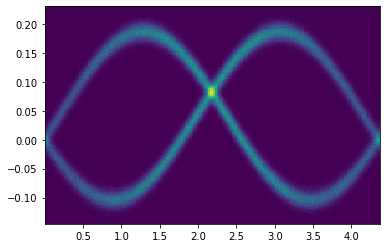

In [18]:
# c_tmod_abs=np.abs(c_tmod)
h,xedges,yedges,image = plt.hist2d(c_tmod_abs, c_ang, weights=c_weight, bins=200);
# h,xedges,yedges,image = plt.hist2d(c_tmod_abs, c_ang,  bins=200);

In [19]:
dataXY, binsXY, dBinXY = ru.hist2np(h, (xedges,yedges))

Using passed freq and edges


In [20]:
len(dataXY[1])

1006387

In [21]:
df_binned =cu.Profile(dataXY[0], dataXY[1], None, nbins=200, xmin=np.min(dataXY[0]), xmax=np.max(dataXY[0]), mean=True, only_binned=True)

In [22]:
x, y, y_e, x_e =df_binned['bincenters'], df_binned['ymean'], df_binned['yerr'], df_binned['xerr']

In [23]:
par, par_e, chi2_ndf = cu.fit_and_chi2(x, y, y_e, cu.thetaY_unblinded_phase, (-0.04, 0.0, 0.04))

Params: [-0.04125351   0.000324941  0.041709868]
Errors: [6.383462877e-05 2.226417194e-04 6.155579961e-05]
𝝌2/dof=2.41


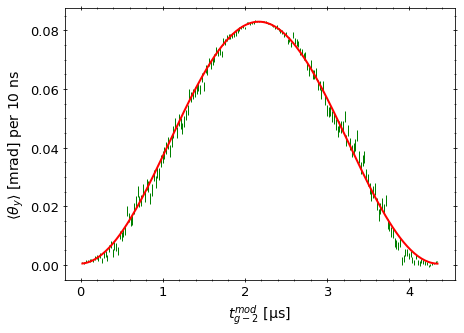

In [24]:
fig, ax = cu.plot(x, y, y_err=y_e, error=True, elw=1, label="Data (sim.)", fs=font_size, tight=False,
                  xlabel=r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]",  ylabel=r"$\langle\theta_y\rangle$ [mrad] per "+str(int(bin_w*1e3))+" ns")
ax.plot(x, cu.thetaY_unblinded_phase(x, *par), c="red", 
        label=r'Fit: $\langle \theta(t) \rangle =  A_{\mathrm{B_z}}\cos(\omega_a t + \phi) + A_{\mathrm{EDM}}\sin(\omega_a t + \phi) + c$', lw=2)